# Setting


> Imports



In [ ]:
import os
import math
import numpy as np
from numpy import array
from numpy import hstack
import pandas as pd
import netCDF4
import xarray as xr
import pickle
import tensorflow as tf
import seaborn as sns

import keras
from keras import layers, losses, regularizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Reshape, LeakyReLU, Cropping2D, RepeatVector, TimeDistributed, LSTM

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, precision_recall_curve

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline



> Check GPU



> Connect to Google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/')
os.getcwd()

# if not os.path.exists('JULES'):
#         os.makedirs('JULES')


'/content/drive/My Drive'


> Download the monthly data from 1961-1900 in advance and deposit it in the cloud folder. The required data is extracted through ``Data_preprocessing.ipynb``and then stored in the **JULES** folder.





## Data preparing




> READ the data from csv


In [ ]:
gb_df = pd.read_csv('JULES/gb_data.csv', index_col=0)
gb_data = gb_df.values
print(gb_data.shape)

gb_df2 = pd.read_csv('JULES/gb_data2.csv', index_col=0)
gb_data2 = gb_df2.values
print(gb_data2.shape)

gb_df3 = pd.read_csv('JULES/gb_data3.csv', index_col=0)
gb_data3 = gb_df3.values
print(gb_data3.shape)

gb_df4 = pd.read_csv('JULES/gb_data4.csv', index_col=0)
gb_data4 = gb_df4.values
print(gb_data4.shape)

gb_df5 = pd.read_csv('JULES/gb_data5.csv', index_col=0)
gb_data5 = gb_df5.values
print(gb_data5.shape)



(360, 21504)
(360, 21504)
(360, 21504)
(360, 21504)
(360, 21504)




> Normalize the interval of the data to 0-1



In [ ]:
scaler = preprocessing.MinMaxScaler()
gb_data = scaler.fit_transform(gb_data)
gb_data = np.array(gb_data, dtype = np.float32)

scaler2 = preprocessing.MinMaxScaler()
gb_data2 = scaler2.fit_transform(gb_data2)
gb_data2 = np.array(gb_data2, dtype = np.float32)

scaler3 = preprocessing.MinMaxScaler()
gb_data3 = scaler3.fit_transform(gb_data3)
gb_data3 = np.array(gb_data3, dtype = np.float32)

scaler4 = preprocessing.MinMaxScaler()
gb_data4 = scaler4.fit_transform(gb_data4)
gb_data4 = np.array(gb_data4, dtype = np.float32)

scaler5 = preprocessing.MinMaxScaler()
gb_data5 = scaler5.fit_transform(gb_data5)
gb_data5 = np.array(gb_data5, dtype = np.float32)





> Check the normalization



In [ ]:
print(np.max(gb_data))
print(np.mean(gb_data))
print(np.min(gb_data))


1.0
0.01690674
0.0




> Splitting the data into training, validation and testing set （5 : 1 : 2）


In [ ]:
total_gb_data = []
total_gb_data.extend(gb_data)
total_gb_data.extend(gb_data2)
total_gb_data.extend(gb_data3)
total_gb_data = np.array(total_gb_data)
print(total_gb_data.shape)


(1080, 21504)


In [ ]:
newarr = np.array_split(total_gb_data, 6)
pca_train = np.vstack((newarr[0], newarr[1], newarr[2], newarr[3], newarr[4]))
pca_test = gb_data4
pca_val = newarr[5]

print(pca_train.shape)
print(pca_val.shape)
print(pca_test.shape)

pca_train = pca_train.astype('float32') # 75 years
pca_val = pca_val.astype('float32') # 15 years
pca_test = pca_test.astype('float32') # 30 years


(900, 21504)
(180, 21504)
(360, 21504)



## PCA Model Testing





> CHECK MSE



In [ ]:
# check mse

def check_mse(comp, original):
  total_mse = []
  for i in range(comp.shape[0]):
    this_mse = np.linalg.norm(comp[i]-original[i]) / (112*192)
    total_mse.append(this_mse)
  total_mse2 = np.array(total_mse)
  print("The average MSE is ", np.mean(total_mse2))
  # print(total_mse2.shape)
  x = range(len(total_mse))
  plt.scatter(x, total_mse, alpha=0.6)
  plt.show()
  return np.mean(total_mse2), total_mse2


The average MSE is  0.00017591819792946492


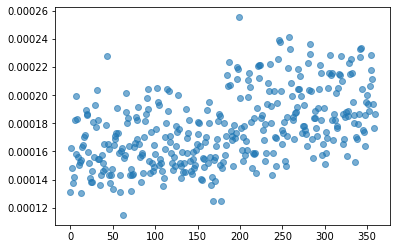

In [ ]:
pca = PCA(n_components=100)# change component number 
pca.fit(pca_train)
encode_test = pca.transform(pca_test)
p4 = pca.inverse_transform(encode_test)
av_pca4, pca_mse4 = check_mse(p4, pca_test)

The average MSE is  0.00017660934701019889


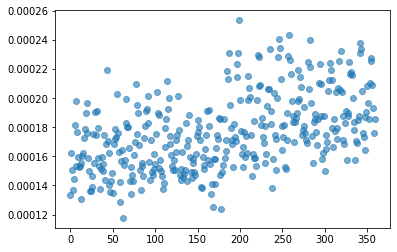

In [ ]:
encode5 = pca.transform(gb_data5)
p5 = pca.inverse_transform(encode5)
av_pca5, pca_mse5 = check_mse(p5, gb_data5)


# LSTM



## Prepare the Climate data




> Encoede the Climate data respectively




1.   Temperature - tair



In [ ]:
# load the data
tair_df = pd.read_csv('JULES/tair.csv', index_col=0)
tair_data = tair_df.values
tair_data[np.isnan(tair_data)] = 0
# normalization the data
min_max_scaler_tair = preprocessing.MinMaxScaler()
tair_data = min_max_scaler_tair.fit_transform(tair_data)
tair_data = np.array(tair_data, dtype = np.float32)

train_val_tair = np.array_split(tair_data, 2)

pca_tair = PCA(n_components=20)
pca_tair.fit(tair_data)

tair_data = pca_tair.transform(tair_data)
train_data_tair = pca_tair.transform(train_val_tair[0])
val_data_tair = pca_tair.transform(train_val_tair[1])

# re-normalizartion
train_tair = preprocessing.MinMaxScaler()
train_data_tair = train_tair.fit_transform(train_data_tair)
val_tair = preprocessing.MinMaxScaler()
val_data_tair = val_tair.fit_transform(val_data_tair)
test_tair = preprocessing.MinMaxScaler()
tair_data = test_tair.fit_transform(tair_data)

print(train_data_tair.shape)
print(val_data_tair.shape)
print(tair_data.shape)


(180, 20)
(180, 20)
(360, 20)


In [ ]:
rain_df = pd.read_csv('JULES/rain.csv', index_col=0)
rain_data = rain_df.values
rain_data[np.isnan(rain_data)] = -0.001
min_max_scaler_rain = preprocessing.MinMaxScaler()
rain_data = min_max_scaler_rain.fit_transform(rain_data)
rain_data = np.array(rain_data, dtype = np.float32)

train_val_rain = np.array_split(rain_data, 2)

pca_rain = PCA(n_components=20)
pca_rain.fit(rain_data)

rain_data = pca_rain.transform(rain_data)
train_data_rain = pca_rain.transform(train_val_rain[0])
val_data_rain = pca_rain.transform(train_val_rain[1])

train_rain = preprocessing.MinMaxScaler()
train_data_rain = train_rain.fit_transform(train_data_rain)
val_rain = preprocessing.MinMaxScaler()
val_data_rain = val_rain.fit_transform(val_data_rain)
test_rain = preprocessing.MinMaxScaler()
rain_data = test_rain.fit_transform(rain_data)

print(train_data_rain.shape)
print(val_data_rain.shape)
print(rain_data.shape)


(180, 20)
(180, 20)
(360, 20)


In [ ]:
qair_df = pd.read_csv('JULES/qair.csv', index_col=0)
qair_data = qair_df.values
qair_data[np.isnan(qair_data)] = -0.001
min_max_scaler_qair = preprocessing.MinMaxScaler()
qair_data = min_max_scaler_tair.fit_transform(qair_data)
qair_data = np.array(qair_data, dtype = np.float32)

train_val_qair = np.array_split(qair_data, 2)

pca_qair = PCA(n_components=20)
pca_qair.fit(qair_data)

qair_data = pca_qair.transform(qair_data)
train_data_qair = pca_qair.transform(train_val_qair[0])
val_data_qair = pca_qair.transform(train_val_qair[1])

train_qair = preprocessing.MinMaxScaler()
train_data_qair = train_qair.fit_transform(train_data_qair)
val_qair = preprocessing.MinMaxScaler()
val_data_qair = val_qair.fit_transform(val_data_qair)
test_qair = preprocessing.MinMaxScaler()
qair_data = test_qair.fit_transform(qair_data)

print(train_data_qair.shape)
print(val_data_qair.shape)
print(qair_data.shape)


(180, 20)
(180, 20)
(360, 20)


In [ ]:
lightning_df = pd.read_csv('JULES/lightning.csv', index_col=0)
lightning_data = lightning_df.values
min_max_scaler_lightning = preprocessing.MinMaxScaler()
lightning_data = min_max_scaler_tair.fit_transform(lightning_data)
lightning_data = np.array(lightning_data, dtype = np.float32)

train_val_lightning = np.array_split(lightning_data, 2)

pca_lightning = PCA(n_components=20)
pca_lightning.fit(lightning_data)

lightning_data = pca_lightning.transform(lightning_data)
train_data_lightning = pca_lightning.transform(train_val_lightning[0])
val_data_lightning = pca_lightning.transform(train_val_lightning[1])

train_lightning = preprocessing.MinMaxScaler()
train_data_lightning = train_lightning.fit_transform(train_data_lightning)
val_lightning = preprocessing.MinMaxScaler()
val_data_lightning = val_lightning.fit_transform(val_data_lightning)
test_lightning = preprocessing.MinMaxScaler()
lightning_data = test_lightning.fit_transform(lightning_data)

print(train_data_lightning.shape)
print(val_data_lightning.shape)
print(lightning_data.shape)


(180, 20)
(180, 20)
(360, 20)


## Prepare the fire data



> Encode and re-normalise the fire data


In [ ]:
# half for training, half for validation
HP3 = np.array_split(gb_data3, 2)
p3_h = newarr[0]
p3_t = newarr[1]

# encoode

train_gb1 = pca.transform(gb_data)
train_gb2 = pca.transform(gb_data2)
train_gb3 = pca.transform(p3_h)
val_data_gb = pca.transform(p3_t)
test_data_gb = pca.transform(gb_data4)
test_data5_gb = pca.transform(gb_data5)

# re-normalization
sc_gb1 = preprocessing.MinMaxScaler()
train_gb1 = sc_gb1.fit_transform(train_gb1)
sc_gb2 = preprocessing.MinMaxScaler()
train_gb2 = sc_gb2.fit_transform(train_gb2)
sc_gb3 = preprocessing.MinMaxScaler()
train_gb3 = sc_gb3.fit_transform(train_gb3)

val_gb = preprocessing.MinMaxScaler()
val_data_gb = val_gb.fit_transform(val_data_gb)
test_gb = preprocessing.MinMaxScaler()
test_data_gb = test_gb.fit_transform(test_data_gb)
test_gb5 = preprocessing.MinMaxScaler()
test_data5_gb = test_gb5.fit_transform(test_data5_gb)


print(train_gb1.shape)
print(train_gb2.shape)
print(train_gb3.shape)
print(val_data_gb.shape)
print(test_data_gb.shape)
print(test_data5_gb.shape)


(360, 100)
(360, 100)
(180, 100)
(180, 100)
(360, 100)
(360, 100)


## Joint the fire and climate data



> A method that can joint the fire and climate data for subsequent LSTM training



In [ ]:
def join_data(gb, tair, rain, qair, lightning):
  join_data = np.zeros((gb.shape[0],100+20*4))
  for i in range(gb.shape[0]):
    coj = []
    coj.extend(gb[i])
    coj.extend(tair[i])
    coj.extend(rain[i])
    coj.extend(qair[i])
    coj.extend(lightning[i])
    coj = np.array(coj)
    coj = np.reshape(coj, (180))
    join_data[i] = coj
  return join_data
  

In [ ]:
train_data1 = join_data(train_gb1,tair_data,rain_data,qair_data,lightning_data)
print(train_data1.shape)
train_data2 = join_data(train_gb2,tair_data,rain_data,qair_data,lightning_data)
print(train_data2.shape)
train_data3 = join_data(train_gb3,train_data_tair,train_data_rain,train_data_qair,train_data_lightning)
print(train_data3.shape)

val_data = join_data(val_data_gb,val_data_tair,val_data_rain,val_data_qair,val_data_lightning)
print(val_data.shape)

test_data = join_data(test_data_gb,tair_data,rain_data,qair_data,lightning_data)
print(test_data.shape)

test_data5 = join_data(test_data5_gb,tair_data,rain_data,qair_data,lightning_data)
print(test_data5.shape)



(360, 180)
(360, 180)
(180, 180)
(180, 180)
(360, 180)
(360, 180)


## Process the data for LSTM training



> Data preprocessing and Data enhencement



In [ ]:
def split_test(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i*12 + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i*12:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# 12 seq predict next 12 seq
n_steps_in, n_steps_out = 12, 12

x_train1, y_train1 = split_sequences(train_data1, n_steps_in, n_steps_out)
print(x_train1.shape, y_train1.shape)
x_train2, y_train2 = split_sequences(train_data2, n_steps_in, n_steps_out)
print(x_train2.shape, y_train2.shape)
x_train3, y_train3 = split_sequences(train_data3, n_steps_in, n_steps_out)
print(x_train3.shape, y_train3.shape)

x_val, y_val = split_sequences(val_data, n_steps_in, n_steps_out)
print(x_val.shape, y_val.shape)

x_test, y_test = split_test(test_data, n_steps_in, n_steps_out)
print(x_test.shape, y_test.shape)
x_test5, y_test5 = split_test(test_data5, n_steps_in, n_steps_out)
print(x_test5.shape, y_test5.shape)


# print (x_test[0], y_test[0])


(337, 12, 180) (337, 12, 180)
(337, 12, 180) (337, 12, 180)
(157, 12, 180) (157, 12, 180)
(157, 12, 180) (157, 12, 180)
(29, 12, 180) (29, 12, 180)
(29, 12, 180) (29, 12, 180)


In [ ]:
x_train = np.vstack((x_train1, x_train2, x_train3))
y_train = np.vstack((y_train1, y_train2, y_train3))
print(x_train.shape, y_train.shape)


(831, 12, 180) (831, 12, 180)


## LSTM Model



> Construct the LSTM Model



In [ ]:
def my_LSTM(n_steps_in, n_steps_out, n_features):
  model = keras.Sequential()
  model.add(LSTM(64, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(64, activation='relu', return_sequences=True))
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.3))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  return model
  

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.val_loss['batch'].append(logs.get('val_loss'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.val_loss['epoch'].append(logs.get('val_loss'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()



> Train the LSTM Model



In [ ]:
lstm_history = LossHistory()
n_features = x_train.shape[2]
lstm_model = my_LSTM(12, 12, n_features)
lstm_model.fit(x_train, y_train, epochs=10000, verbose=1, callbacks=[lstm_history], validation_data =(x_val, y_val))


In [ ]:
# Draw acc-loss plots
lstm_history.loss_plot('epoch')



> Save the trained LSTM model



In [ ]:
# from keras.models import save_model
# lstm_model.save("JULES/lstm_pca_model_100.h5")




> Load the trained LSTM model



In [ ]:
lstm_model = load_model('JULES/lstm_pca_model_100.h5')


In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                62720     
                                                                 
 repeat_vector (RepeatVector  (None, 12, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 64)            33024     
                                                                 
 dense (Dense)               (None, 12, 100)           6500      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12, 100)           0         
                                                                 
 time_distributed (TimeDistr  (None, 12, 180)          18180     
 ibuted)                                                

## LSTM model testing


### Prepare the Testing data



> Prepare the testing data




In [ ]:
rest_test_data = np.zeros((29, 12, 180))
first_test_data = np.zeros((1, 12, 180))
first_test_data = x_test[0]
first_test_data = np.reshape(first_test_data, (1, 12, 180))
rest_test_data = y_test

print(rest_test_data.shape)
print(first_test_data.shape)


(29, 12, 180)
(1, 12, 180)


In [ ]:
rest_test_data5 = np.zeros((29, 12, 180))
first_test_data5 = np.zeros((1, 12, 180))
first_test_data5 = x_test5[0]
first_test_data5 = np.reshape(first_test_data5, (1, 12, 180))
rest_test_data5 = y_test5

print(rest_test_data5.shape)
print(first_test_data5.shape)


(29, 12, 180)
(1, 12, 180)




> The original data for latter comparison



In [ ]:
original_test_data = np.zeros((348,21504))
for i in range(348):
  original_test_data[i] = pca_test[i+12]
print(original_test_data.shape)


(348, 21504)


In [ ]:
original_test_data5 = np.zeros((348,21504))
for i in range(348):
  original_test_data5[i] = gb_data5[i+12]
print(original_test_data5.shape)


(348, 21504)


### Without Data Assimilation



> Iterative prediction



In [ ]:
def inner_prediction(input_year):
  this_year = lstm_model.predict(input_year, verbose=0)
  return this_year

def y_mse(comp, original):
  total_mse = []
  for i in range(comp.shape[0]):
    this_mse = np.linalg.norm(comp[i]-original[i]) / (112*192)
    total_mse.append(this_mse)
  total_mse2 = np.array(total_mse)
  return np.mean(total_mse2)

def iterative_prediction(first_year, label_years, original_data, begin_year):
  times = label_years.shape[0]
  predict_years = np.zeros((times, 12, 180))
  this_year = first_year
  for i in range(times):
    this_year = inner_prediction(this_year)
    predict_years[i] = this_year[0]
  y_predict = np.reshape(predict_years, (12*times, 180))
  prediction = y_predict[:,:100]
  prediction = test_gb.inverse_transform(prediction)
  y_decode = pca.inverse_transform(prediction)

  year_mse = []
  pred_year = np.array_split(y_decode, times)
  ori_year = np.array_split(original_data, times)

  for j in range(times):
    this_year_mse = y_mse(pred_year[j], ori_year[j])
    year_mse.append(this_year_mse)
  x = list(range(begin_year+1, begin_year+times+1))
  plt.plot(x, year_mse,'bo-', alpha=0.4)
  plt.title("The average mse for each predicted year (100 Latent Space)")
  plt.xlabel("Years")
  plt.ylabel("Average year mse for prediction")
  plt.show()
  return y_decode, np.mean(year_mse), year_mse



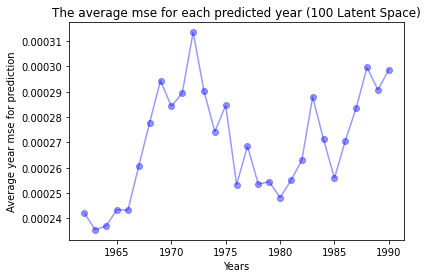

The average mse with testing data4 of prediction is:  0.0002698088461545254


In [ ]:
y_decode4, average_mse4, test_mse4 = iterative_prediction(first_test_data, rest_test_data, original_test_data, 1961)
print("The average mse with testing data4 of prediction is: ", average_mse4)


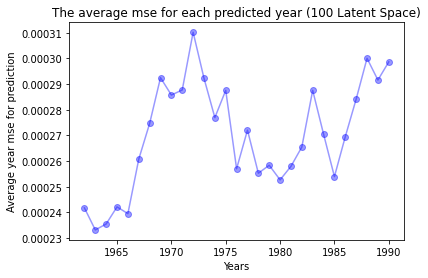

The average mse with testing data5 of prediction is:  0.0002701989285070178


In [ ]:
y_decode5, average_mse5, test_mse5 = iterative_prediction(first_test_data5, rest_test_data5, original_test_data5, 1961)
print("The average mse with testing data5 of prediction is: ", average_mse5)



> Plot the MSE between the data predicted by the 1961 data for the following 29 years (1962-1990) and the original data

### Data Assimilation



In [ ]:
def VAR_3D(xb,Y,sigma_B,sigma_R): 
    H = np.eye(xb.size)
    B = sigma_B * np.eye(xb.size)
    R = sigma_R * np.eye(Y.size)
    dim_x = xb.size
    #dim_y = Y.size
    Y.shape = (Y.size,1)
    xb1=np.copy(xb)
    xb1.shape=(xb1.size,1)
    K=np.dot(B,np.dot(np.transpose(H),np.linalg.pinv(np.dot(H,np.dot(B,np.transpose(H)))+R)))
    
    #add condition number
    #print('condition number K',np.linalg.norm(K))
    A=np.dot(np.dot((np.eye(dim_x)-np.dot(K,H)),B),np.transpose((np.eye(dim_x)-np.dot(K,H))))+np.dot(np.dot(K,R),np.transpose(K))
    vect=np.dot(H,xb1)
    xa=np.copy(xb1+np.dot(K,(Y-vect)))
    return xa,A

def iterative_prediction_DA(first_year, label_years, original_data, begin_year, sigma_B, sigma_R):
  times = label_years.shape[0]
  predict_years = np.zeros((times, 12, 180))
  this_year = first_year
  obs_year = np.array_split(label_years, times)

  for i in range(times):
    this_year = inner_prediction(this_year)
    if i%5 == 0:
      da,_ = VAR_3D(this_year, obs_year[i], sigma_B, sigma_R)
      this_year = np.reshape(da, (1, 12, 180))
    predict_years[i] = this_year[0]
  y_predict = np.reshape(predict_years, (12*times, 180))
  prediction = y_predict[:,:100]
  prediction = test_gb.inverse_transform(prediction)
  y_decode = pca.inverse_transform(prediction)

  year_mse = []
  pred_year = np.array_split(y_decode, times)
  ori_year = np.array_split(original_data, times)

  for j in range(times):
    this_year_mse = y_mse(pred_year[j], ori_year[j])
    year_mse.append(this_year_mse)
  x = list(range(begin_year+1, begin_year+times+1))
  plt.plot(x, year_mse,'bo-', alpha=0.4)
  plt.title("The average mse for each predicted year (100 Latent Space)")
  plt.xlabel("Years")
  plt.ylabel("Average year mse for prediction")
  plt.show()
  return y_decode, np.mean(year_mse), year_mse


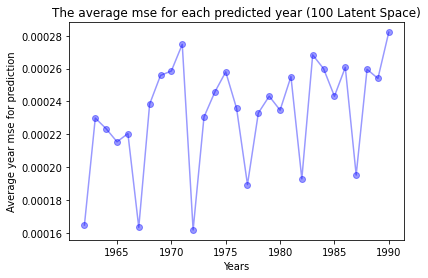

The average mse for testing data4 is:  0.0002327166963183805


In [ ]:
y_decode_da4, average_mse_da4, test_mse_da4 = iterative_prediction_DA(first_test_data, rest_test_data, original_test_data, 1961, 1, 0.1) # combine two figures
print("The average mse for testing data4 is: ", average_mse_da4)


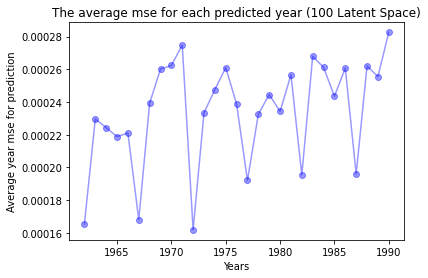

The average mse for testing data5 is:  0.00023416227702658177


In [ ]:
y_decode_da5, average_mse_da5, test_mse_da5 = iterative_prediction_DA(first_test_data5, rest_test_data5, original_test_data5, 1961, 1, 0.1) # combine two figures
print("The average mse for testing data5 is: ", average_mse_da5)


# Final result comparison

In [ ]:
from tensorflow.python.framework.ops import name_from_scope_name
def comp_methods(cae, cae_lstm, cae_lstm_da, begin_year, file_name):
  times = len(cae_lstm)
  cae_pro = []
  sp_cae = np.array_split(cae, 30)
  for i in range(times):
    cae_pro.append(np.mean(sp_cae[i+1]))
  x = list(range(begin_year+1, begin_year+times+1))
  plt.plot(x, cae_pro,'bo-', alpha=0.4, label = "PCA")
  plt.plot(x, cae_lstm,'go-', alpha=0.4, label = "PCA_LSTM")
  plt.plot(x, cae_lstm_da,'ro-', alpha=0.4, label = "PCA_LSTM_DA")
  # plt.title("The average mse for each method (20 Latent Space)")
  plt.xlabel("Years", font1)
  plt.ylabel("Average year MSE", font1)
  plt.ylim([0.000120, 0.000340])
  plt.legend()
  plt.savefig("output_figure/"+str(file_name)+".png",bbox_inches='tight', dpi=300)
  plt.show()
  return np.mean(cae_pro), np.mean(cae_lstm), np.mean(cae_lstm_da)


font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 14,
}

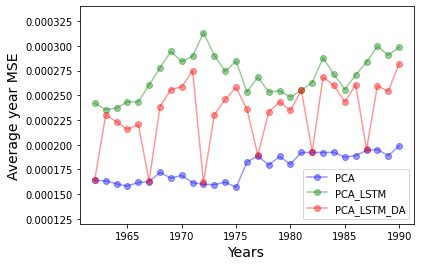

In [ ]:
c4, cl4, cad4 = comp_methods(pca_mse4, test_mse4, test_mse_da4, 1961, "PCA_100_p4")


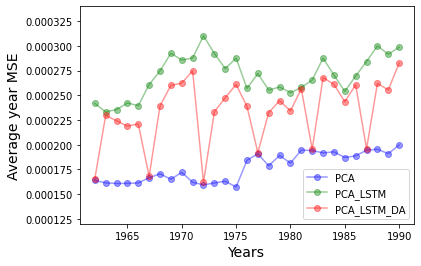

In [ ]:
c5, cl5, cad5 = comp_methods(pca_mse5, test_mse5, test_mse_da5, 1961, "PCA_100_p5")


In [ ]:
def show_comp_methods(original_test_data, cae, cae_lstm, cae_lstm_da, begin_year, interval_year):
  original_test_data = np.reshape(original_test_data,(348, 112, 192))
  cae = np.reshape(cae, (360, 112, 192))
  cae_lstm = np.reshape(cae_lstm, (348, 112, 192))
  cae_lstm_da = np.reshape(cae_lstm_da, (348, 112, 192))
  plt.figure(figsize=(24, 12), facecolor='w')
  monthly_field = np.zeros((112, 192))
  norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
  for j in range(3):
    plt.subplot(4, 3, j+1)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} oringinal')
    plt.imshow(monthly_field)
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(norm=norm) 
    sm.set_array([])
    plt.colorbar(sm)
  for j in range(3):
    plt.subplot(4, 3, j+4)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(cae[(begin_year+1-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} CAE prediction (20)')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
  for j in range(3):
    plt.subplot(4, 3, j+7)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} PCA+LSTM prediction (100)')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
  for j in range(3):
    plt.subplot(4, 3, j+10)
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+interval_year*j*12][i][k])
    plt.title(f'The {j + 1} PCA+LSTM_DA prediction (100)')
    plt.imshow(monthly_field)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
  plt.show()



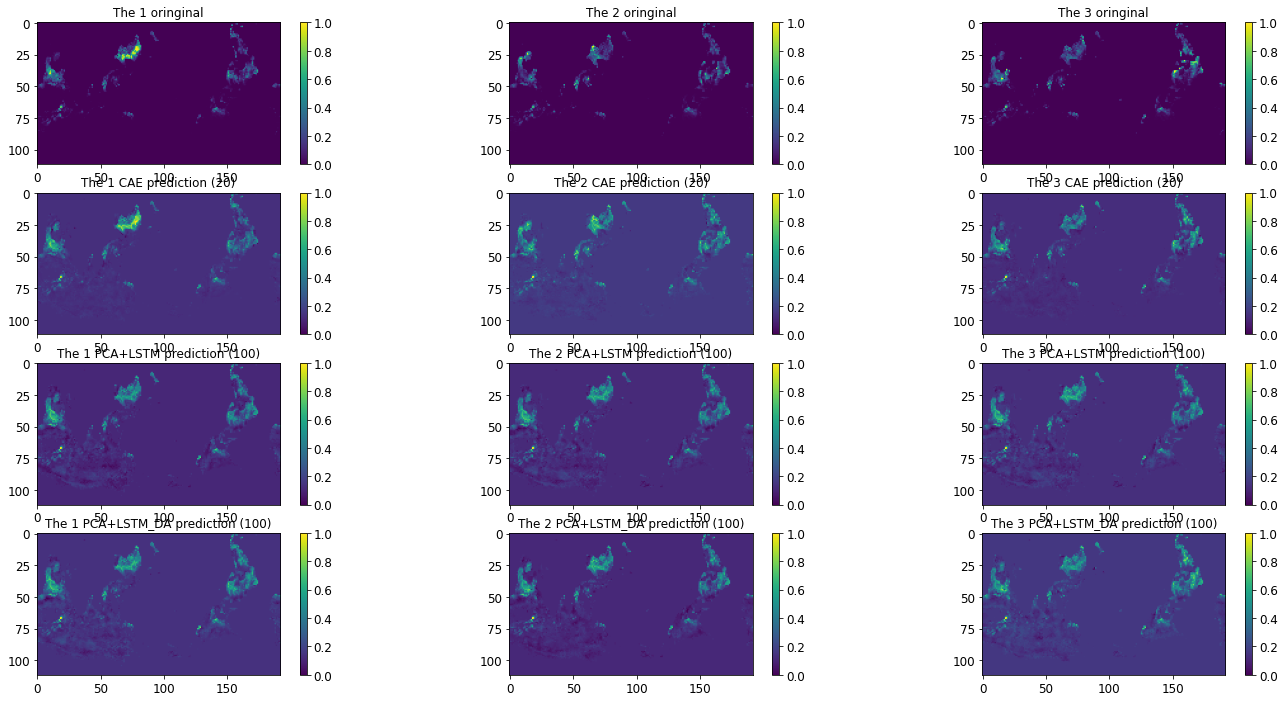

In [ ]:
show_comp_methods(original_test_data, p4, y_decode4, y_decode_da4, 17, 5)


In [ ]:
show_comp_methods(original_test_data5, p5, y_decode5, y_decode_da5, 17, 5)


In [ ]:
def save_comp_methods(original_test_data, cae, cae_lstm, cae_lstm_da, begin_year, interval_year):
  original_test_data = np.reshape(original_test_data,(348, 112, 192))
  cae = np.reshape(cae, (360, 112, 192))
  cae_lstm = np.reshape(cae_lstm, (348, 112, 192))
  cae_lstm_da = np.reshape(cae_lstm_da, (348, 112, 192))
  plt.figure(figsize=(24, 12), facecolor='w')
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(original_test_data[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/pca_100/orig_"+str(j)+".png", bbox_inches='tight', dpi=300)
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(cae[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/pca_100/pca_"+str(j)+".png",bbox_inches='tight', dpi=300)
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(cae_lstm[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/pca_100/lstm_"+str(j)+".png",bbox_inches='tight', dpi=300)
  for j in range(4):
    plt.figure(figsize=(24, 12), facecolor='w')
    monthly_field = np.zeros((112, 192))
    for i in range(112):
        for k in range(192):
          if j == 0:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12][~i][k])
          elif j == 2:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+interval_year*12][~i][k])
          elif j ==1:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+6][~i][k])
          else:
            monthly_field[i,k] = np.array(cae_lstm_da[(begin_year-1)*12+interval_year*12+6][~i][k])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(monthly_field)
    plt.savefig("output_figure/pca_100/la_"+str(j)+".png",bbox_inches='tight', dpi=300)
  plt.show()


In [ ]:
save_comp_methods(original_test_data, p4, y_decode4, y_decode_da4, 22, 5)